In [28]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy Libraries
from scipy.io import arff
from scipy.io.arff import loadarff

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score, precision_score,
                            recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Boosting Libraries
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv1D, Dense, Dropout, Flatten, 
                                    GlobalAveragePooling1D, GlobalMaxPooling1D, LeakyReLU, MaxPooling1D, 
                                    ReLU)
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Plotting settings
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # minus 표시

# # 행 표시
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 10)

import os
import librosa.display
import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from pathlib import Path
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')


In [29]:
import glob

abnorm_files = glob.glob('/Users/park/play/data/audio/abnorm/*.wav')
normal_files = glob.glob('/Users/park/play/data/audio/normal/*.wav')
all_files = abnorm_files + normal_files
print(len(abnorm_files))
print(len(normal_files))
print(len(all_files))
abnorm_files[0]

293
55
348


'/Users/park/play/data/audio/abnorm/abnorm_278.wav'

In [30]:
# wave 파일에 대한 sample rate와 data 형식 확인 (2D data)
# - stereo 오디오 형식으로 처리함 (왼쪽, 오른쪽)
# - 원시 PCM 데이터를 정수형식으로 반환
# - 원래 오디오파일의 sampling rate를 반환
sample_rate, data = sio.wavfile.read(abnorm_files[0])
print(sample_rate) # 1초당 샘플링 되는 횟수
print(data.shape)

192000
(587536, 2)


### # waveform, stft, stft_db, mfcc 하나씩 살펴보기

- waveform

---

In [31]:
# waveform 파일로 변환하기 (1D data)
# - mono 오디오 형식으로 처리함 (stereo 두 채널의 평균값)
# - -1~1 사이의 값으로 반환
# - sampling rate 기본 설정 : 22050, 사용자가 설정할 수 있음
# -> 오디오 분석 시 주로 사용
y, sr = librosa.load(abnorm_files[0], sr=sample_rate)
print(sr)
print(y.shape)

192000
(587536,)


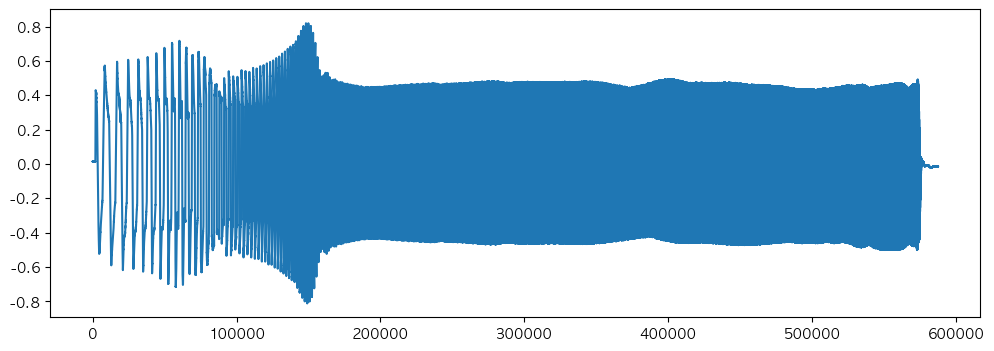

In [32]:
# waveform(y) 시각화
# - x : sampling rate의 샘플 번호
# - y : 진폭 (주파수 아님, 주파수를 보고싶다면 stft, mfcc 변환)
plt.figure(figsize=(12,4))
plt.plot(y)

- stft

---

(1025, 1148)


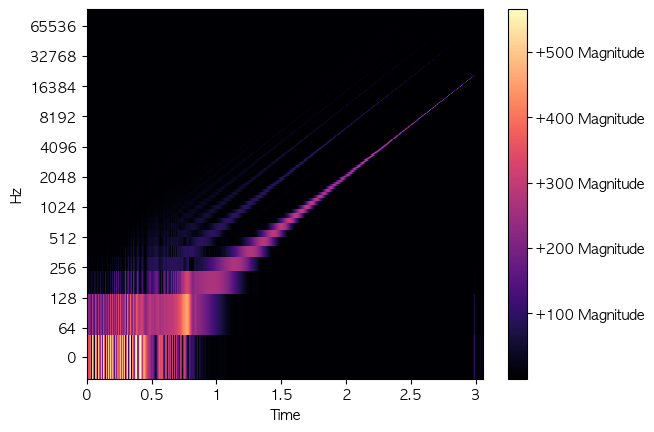

In [33]:
# stft(spectogram)은 복소수 형태 (실수+허수)
# - 시각화를 위해서는 np.abs()처리 -> specshow() 사용 시각화
# - (1025, 1148) : 1025개의 주파수 bin, 1148개의 시간 frame
# -> stft를 구하는 목적 : 시간에 따른 주파수 성분의 변화를 분석, 시각화 하기 위함
stft = librosa.stft(y)
print(stft.shape)
librosa.display.specshow(np.abs(stft), sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f Magnitude") # 복소수의 크기 : 진폭
plt.show()

# 인간의 청각은 주파수에 대해 로그 스케일로 반응 (주파수 차이를 절대적인 헤르츠 값보다는 상대적인 비율로 인식)
# 이러한 인간의 청각 특성을 반영하기 위해 주파수 축을 로그 스케일로 표시
# 로그 스케일에서는 낮은 주파수 대역이 더 넓게 표시되고, 높은 주파수 대역은 더 좁게 표시
# - 스펙트로그램에서 낮은 주파수 영역의 세부 사항을 더 잘 볼 수 있음

- stft_db

---

(1025, 1148)


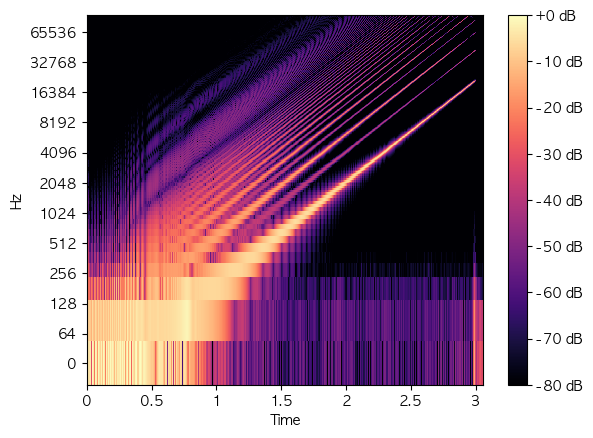

In [34]:
# librosa.amplitude_to_db() : stft의 진폭을 데시벨로 변환(스케일링)
# -> 인간의 청각 특성과 맞추기 위해

stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(stft_db.shape)
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.show()


- mfcc

---

(50, 1148)


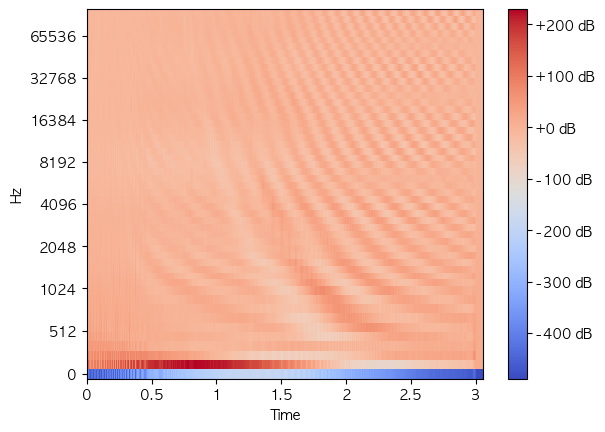

In [35]:
# MFCC는 음성 및 오디오 데이터의 복잡성을 줄이면서도 중요한 특성을 효과적으로 캡처하여,
# 다양한 오디오 처리 작업에 적합한 특징 벡터를 제공
# Mel 스케일링 : 인간의 청각 특성을 반영
# log 스케일링 : 주로 수학적 특성 또는 데이터 분포를 조정하기 위해 사용
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=50)
print(mfcc.shape)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.show()

In [36]:
mfcc

array([[-421.9793   , -451.2254   , -479.42282  , ..., -488.08127  ,
        -484.1706   , -434.39313  ],
       [  85.45706  ,   58.926376 ,   25.640766 , ...,   14.666274 ,
          19.947659 ,   75.43064  ],
       [  39.276253 ,   39.98502  ,   22.060402 , ...,   14.518234 ,
          19.08965  ,   42.147877 ],
       ...,
       [  -2.9853525,   -3.781912 ,   -4.8407345, ...,   -5.555068 ,
          -4.142418 ,   -3.1252053],
       [  -3.2670317,   -4.12461  ,   -5.153948 , ...,   -5.7495284,
          -4.20475  ,   -3.707605 ],
       [  -3.7441723,   -4.753266 ,   -5.4302297, ...,   -5.923916 ,
          -4.3411007,   -4.4254594]], dtype=float32)

### # waveform, stft, stft_db, mfcc 전체파일 리스트 만들기
### # 라벨 리스트 만들기

In [37]:
print(len(abnorm_files), len(normal_files), len(all_files))
# 모든 파일 리스트
all_files.sort()

# 라벨 리스트 만들기
label_0 = np.array([0]*len(abnorm_files))
label_1 = np.array([1]*len(normal_files))
label = np.append(label_0, label_1)

293 55 348


In [38]:
# wave_list 만들기
wave_list = []
for file in all_files:
    y, sr = librosa.load(file, sr=sample_rate)
    wave_list.append(y)

wave_list = np.array(wave_list)
print(wave_list.shape)

(348, 587536)


In [39]:
# stft_list, db_list 만들기
stft_list = []
db_list = []

for file in all_files:
    y, sr = librosa.load(file, sr=sample_rate)
    stft = librosa.stft(y)
    stft_list.append(stft)
    stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    db_list.append(stft_db)
    
stft_list = np.array(stft_list)
db_list = np.array(db_list)
print(stft_list.shape)
print(db_list.shape)

(348, 1025, 1148)
(348, 1025, 1148)


In [40]:
# mfcc_list 만들기
mfcc_list = []
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=50)

for file in all_files:
    y, sr = librosa.load(file, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=50)
    mfcc_list.append(y)

mfcc_list = np.array(mfcc_list)
print(mfcc_list.shape)

(348, 587536)


In [41]:
mfcc_list

array([[ 0.01038432,  0.01062888,  0.0105986 , ..., -0.01373845,
        -0.01386619, -0.01357883],
       [ 0.01148111,  0.01150125,  0.01134312, ..., -0.01259416,
        -0.01229835, -0.01266664],
       [ 0.00714099,  0.0071196 ,  0.00700599, ..., -0.01288712,
        -0.01290756, -0.01277566],
       ...,
       [ 0.00197339,  0.00202858,  0.00203055, ..., -0.00479543,
        -0.00488299, -0.00477213],
       [ 0.01182002,  0.01161224,  0.01198494, ..., -0.01095837,
        -0.01121658, -0.01132548],
       [ 0.00848889,  0.00864929,  0.00864208, ..., -0.0121851 ,
        -0.0123648 , -0.01236618]], dtype=float32)

In [43]:
# 전체 파일을 불러와서 spectogram, stft, stft_db, mfcc 4가지 형태의 리스트로 저장하기
# 매칭되는 라벨 리스트 만들기

# train, test dataset 구분하기

# LSTM으로 4가지 데이터셋 모두 학습 해보기(waveform, mfcc, stft, stft_db)

# waveform(y) - 1D : 머신러닝, dnn, cnn으로 학습 -> 데이터가 커서 머신러닝은 안될 수도...
# mfcc, stft, stft_db - 2D : cnn으로 학습